In [1]:
%matplotlib inline
import cv2
import numpy as np

# Auxiliar Functions

In [2]:
def invertChannels(img):
    b,g,r = cv2.split(img) # split channels
    return cv2.merge((r,g,b)) # merge in rgb order to display with matplotlib

In [3]:
# power law tranformation
def power_law_lut(c, g):
    table = np.zeros(256,'uint8')

    table = np.array([( c * (i / 255.0) ** g) * 255 for i in np.arange(0, 256)]).astype("uint8")

    return np.array([table.astype('uint8')])

In [4]:
# mean square error
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    return err

# FingerPrint Enchancement

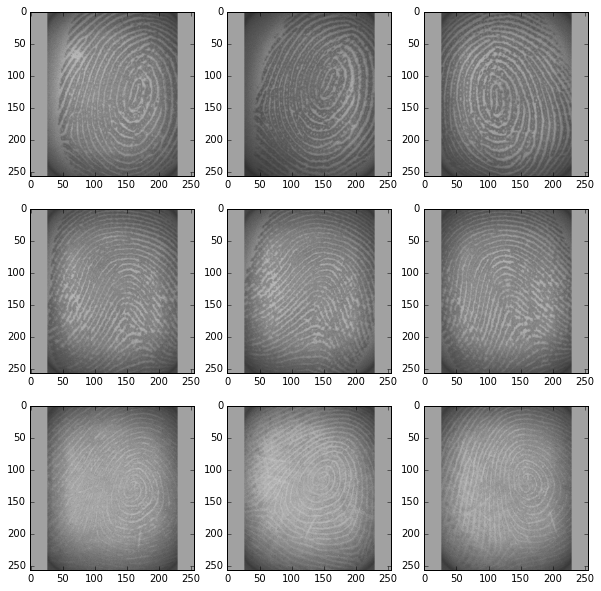

In [5]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

img11 = cv2.imread('../fingerprintDB/#1/11.bmp')
img12 = cv2.imread('../fingerprintDB/#1/12.bmp')
img13 = cv2.imread('../fingerprintDB/#1/13.bmp')

img21 = cv2.imread('../fingerprintDB/#2/21.bmp')
img22 = cv2.imread('../fingerprintDB/#2/22.bmp')
img23 = cv2.imread('../fingerprintDB/#2/23.bmp')

img31 = cv2.imread('../fingerprintDB/#3/31.bmp')
img32 = cv2.imread('../fingerprintDB/#3/32.bmp')
img33 = cv2.imread('../fingerprintDB/#3/33.bmp')

plt.figure(figsize=(10,10)) 

plt.subplot(331)
plt.imshow(invertChannels(img11))
plt.subplot(332)
plt.imshow(invertChannels(img12))
plt.subplot(333)
plt.imshow(invertChannels(img13))

plt.subplot(334)
plt.imshow(invertChannels(img21))
plt.subplot(335)
plt.imshow(invertChannels(img22))
plt.subplot(336)
plt.imshow(invertChannels(img23))


plt.subplot(337)
plt.imshow(invertChannels(img31))
plt.subplot(338)
plt.imshow(invertChannels(img32))
plt.subplot(339)
plt.imshow(invertChannels(img33))

## crop around

In [6]:
def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

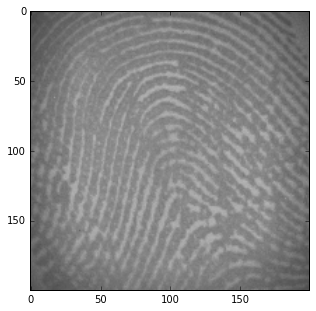

In [39]:
img21_cropped = crop_around_center(img23, 200 , 200)

plt.figure(figsize=(5,5)) 
plt.imshow(invertChannels(img21_cropped),cmap='Greys')

# Convert to grayscale

In [40]:
img21_cropped[:,:,1]

array([[73, 71, 75, ..., 85, 85, 81],
       [71, 76, 82, ..., 87, 82, 79],
       [76, 79, 84, ..., 87, 85, 88],
       ..., 
       [84, 86, 86, ..., 82, 81, 79],
       [80, 85, 90, ..., 78, 78, 82],
       [85, 86, 84, ..., 83, 82, 83]], dtype=uint8)

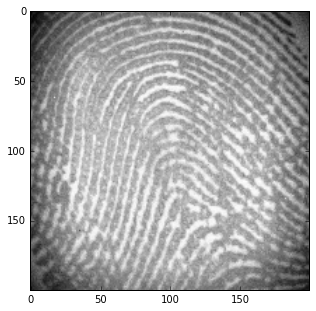

In [41]:
#skip
#convert to grayscale
b,g,r = cv2.split(img21_cropped)
img21_cropped_gray = img21_cropped[:,:,0]
#img21_cropped_gray = cv2.cvtColor(img21_cropped,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5,5)) 
plt.imshow(img21_cropped_gray,cmap='Greys_r')

# Pre-Processing

In [42]:
img21_cropped_gray.shape

(200, 200)

## Contrast Streching

In [43]:
img21_cropped_gray[5,5]

81

(0, 256)

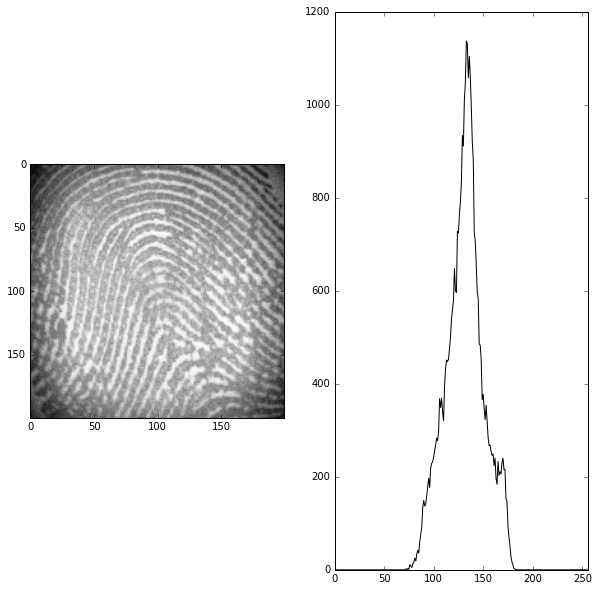

In [44]:
plt.figure(figsize=(10,10)) 
plt.subplot(121)
plt.imshow(img21_cropped_gray,cmap='Greys_r')

plt.subplot(122)
histr = cv2.calcHist([img21_cropped_gray],[0],None,[256],[0,255])
plt.plot(histr,color = 'k')
plt.xlim([0,256])  

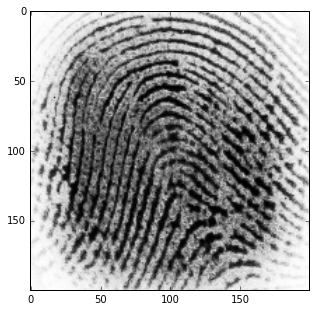

In [45]:
plt.figure(figsize=(5,5))
img21_cropped_gray = cv2.equalizeHist(img21_cropped_gray)
plt.imshow(img21_cropped_gray,cmap='Greys')

# Smoothing

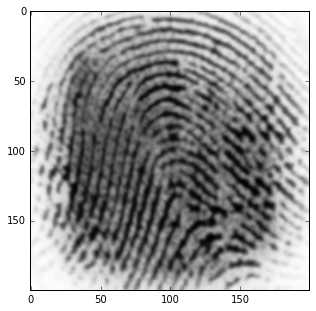

In [46]:
plt.figure(figsize=(5,5))
img21_blur = cv2.GaussianBlur(img21_cropped_gray,(5,5),0)
plt.imshow(img21_blur,cmap='Greys')

# Binarization

In [47]:
# with overlap
def block_process_overlap(a, blocksize, overlap, filt, args):
    b = np.empty(a.shape)
    
    for row in range(0, a.shape[0] - overlap, blocksize - overlap ):
        for col in range(0, a.shape[1] - overlap, blocksize - overlap ):
            b[col:col + blocksize, row:row + blocksize] = (
                filt(a[col:col + blocksize, row:row + blocksize], *args))
    return b

In [48]:
def block_process(a, blocksize, filt, args):
    b = np.empty(a.shape)
    for row in xrange(0, a.shape[0], blocksize):
        for col in xrange(0, a.shape[1], blocksize):                            
            b[col:col + blocksize, row:row + blocksize] = (
                filt(a[col:col + blocksize, row:row + blocksize], *args))
    return b

In [49]:
def binarize_mean(img):
    
    mean = np.mean(img)
    
    img_binarize = np.empty([img.shape[0], img.shape[1]])
                            
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] >= mean:
                img_binarize[i,j] = 1
            else:
                img_binarize[i,j] = 0
    return img_binarize                     

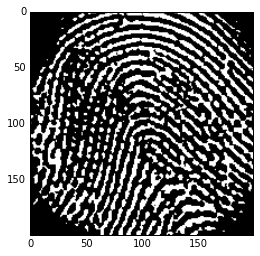

In [73]:
#i_binarization = block_process(img21_blur, 8, binarize_mean, ())
i_binarization = binarize_mean(img21_blur)
i_binarization = cv2.adaptiveThreshold(img21_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21, 15);
plt.imshow(i_binarization,cmap='Greys')

# FFT Enchancement

In [74]:
def filter_fft(block, k):        
    dft = cv2.dft(np.float32(block), flags = cv2.DFT_COMPLEX_OUTPUT)    
    #dft_tmp = dft * abs(dft)**k
    dft_tmp = dft * np.absolute(dft)**k    
    img_back = cv2.idft(dft_tmp)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])    
    return img_back

In [382]:
#iench = block_process(img12_preprocessed, 2, filter_fft, (0.9,))
iench = block_process_overlap(i_binarization, 32, 8,filter_fft, (0.9,))
#iench = block_process(i_bin, 10, filter_fft, (0.01,))
#iench = filter_fft(i_binarization,0.45)
iench *= 255.0/iench.max()
iench = iench.astype('uint8')
#iench = cv2.equalizeHist(iench.astype('uint8'))

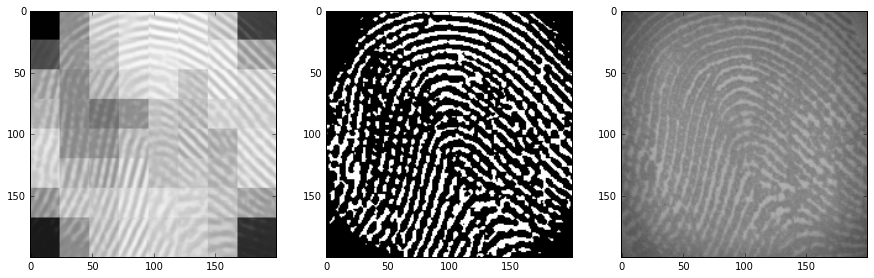

In [383]:
plt.figure(figsize=(15,15)) 
plt.subplot(131)
plt.imshow(iench,cmap='Greys')
plt.subplot(132)
plt.imshow(i_binarization,cmap='Greys')
plt.subplot(133)
plt.imshow(img21_cropped,cmap='Greys')

(0, 256)

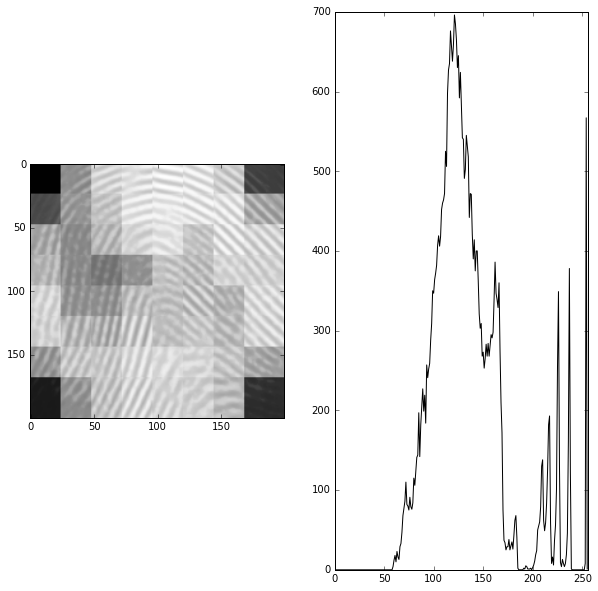

In [362]:
plt.figure(figsize=(10,10)) 
plt.subplot(121)
plt.imshow(iench,cmap='Greys')

plt.subplot(122)
histr = cv2.calcHist([iench],[0],None,[256],[0,256])
plt.plot(histr,color = 'k')
plt.xlim([0,256])  

# Local contrast optimization

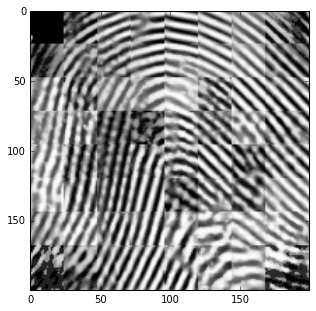

In [364]:
plt.figure(figsize=(5,5))
iench1 = block_process_overlap(iench, 32,8, cv2.equalizeHist, ())
plt.imshow(iench1,cmap='Greys')

# Local Binarization

In [365]:
def binarize_mean(img):
    
    mean = np.mean(img) - 10
    
    img_binarize = np.empty([img.shape[0], img.shape[1]])
                            
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] >= mean:
                img_binarize[i,j] = 1
            else:
                img_binarize[i,j] = 0
    return img_binarize  

In [366]:
iench_binarization_0 = block_process_overlap(iench1, 32, 8, binarize_mean, ())
iench_binarization_1 = binarize_mean(iench1)
#iench_binarization_2 = cv2.adaptiveThreshold(iench1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 15);

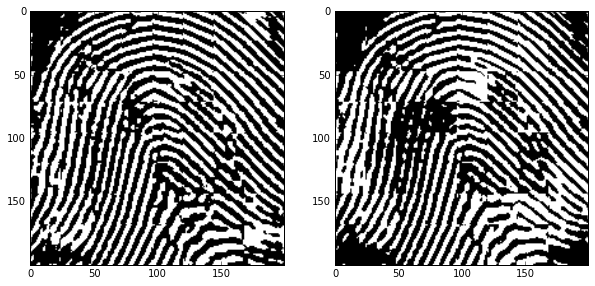

In [367]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(iench_binarization_0,cmap='Greys')
plt.subplot(122)
plt.imshow(iench_binarization_1,cmap='Greys')
#plt.subplot(133)
#plt.imshow(iench_binarization_2,cmap='Greys')

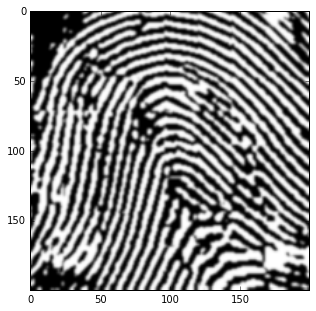

In [368]:
plt.figure(figsize=(5,5))
iench_binarization_smooth = cv2.GaussianBlur(iench_binarization_0,(5,5),1)
plt.imshow(iench_binarization_smooth,cmap='Greys')

# Limpar Ruido Closing

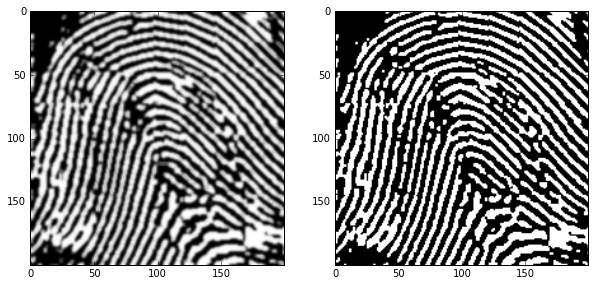

In [370]:
plt.figure(figsize=(10,10))
plt.subplot(121)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
iench_bin_closed = cv2.morphologyEx(iench_binarization_smooth, cv2.MORPH_CLOSE, kernel)
plt.imshow(iench_bin_closed,cmap='Greys')

plt.subplot(122)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
iench_bin_closed_1 = cv2.morphologyEx(iench_binarization_0, cv2.MORPH_CLOSE, kernel)
plt.imshow(iench_bin_closed_1,cmap='Greys')

# Thinning

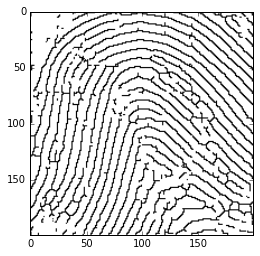

In [373]:
import pymorph as pm

img_thin = pm.thin(pm.binary(1 - iench_binarization_0))

plt.imshow(img_thin,cmap='Greys')

# Detect minuteas

In [400]:
kernel = np.array([[1,0,1],[0,1,0],[0,0,1]])

counter = 0
for i in range(img_thin.shape[0]):
    for j in range(img_thin.shape[1]):
        

array([[1, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

# Gabor filtering

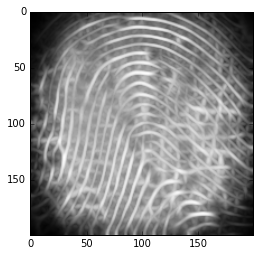

In [391]:
# TODO
#https://cvtuts.wordpress.com/2014/04/27/gabor-filters-a-practical-overview/

def build_filters():
    filters = []
    ksize = 12
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 3.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

filters = build_filters()
 
res1 = process(img21_cropped_gray, filters)
plt.imshow(res1,cmap='Greys_r')